# **Import thư viện**

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

2025-09-08 02:30:28.586621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-08 02:30:28.586784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-08 02:30:28.732382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Đọc dữ liệu**

**Dữ liệu FPT**

In [2]:
df_fpt = pd.read_csv("/kaggle/input/datasetcv/FPT.csv")
df_fpt

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
...,...,...,...,...,...,...,...,...
97401,FPT,12/22/2020 14:24,58.20,58.20,58.20,58.20,27470,0
97402,FPT,12/22/2020 14:25,58.20,58.20,58.20,58.20,14820,0
97403,FPT,12/22/2020 14:26,58.20,58.20,58.20,58.20,500,0
97404,FPT,12/22/2020 14:29,58.10,58.10,58.10,58.10,2500,0


In [3]:
df_fpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


In [4]:
df_fpt.describe()

,Open,High,Low,Close,Volume,Open Interest
count,97406.000000,97406.000000,97406.000000,97406.000000,9.740600e+04,97406.0
mean,45.071630,45.090138,45.051430,45.071631,8.044173e+03,0.0
std,6.359803,6.364950,6.354245,6.359799,1.753203e+04,0.0
min,30.250000,30.250000,30.220000,30.250000,1.000000e+01,0.0
25%,39.740000,39.740000,39.700000,39.740000,7.500000e+02,0.0
50%,46.950000,46.950000,46.950000,46.950000,2.960000e+03,0.0
75%,49.200000,49.250000,49.170000,49.200000,8.960000e+03,0.0
max,58.400000,58.500000,58.400000,58.400000,1.255930e+06,0.0


# **Tiền xử lý dữ liệu FPT**

In [5]:
#Hàm tiền xử lý
def preprocess_datetime(df):
    #Chuyển đổi cột Date/Time sang định dạng datetime
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    return df

In [6]:
df_fpt = preprocess_datetime(df_fpt)
df_fpt.head(10)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410,0
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190,0
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120,0
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120,0
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500,0
5,FPT,2018-12-25 09:20:00,30.74,30.74,30.70,30.74,7140,0
6,FPT,2018-12-25 09:21:00,30.66,30.74,30.59,30.66,16480,0
7,FPT,2018-12-26 09:15:00,31.04,31.11,31.04,31.11,2650,0
8,FPT,2018-12-26 09:16:00,31.19,31.19,31.19,31.19,500,0
9,FPT,2018-12-26 09:17:00,31.11,31.19,31.11,31.19,510,0


# **Visualize**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

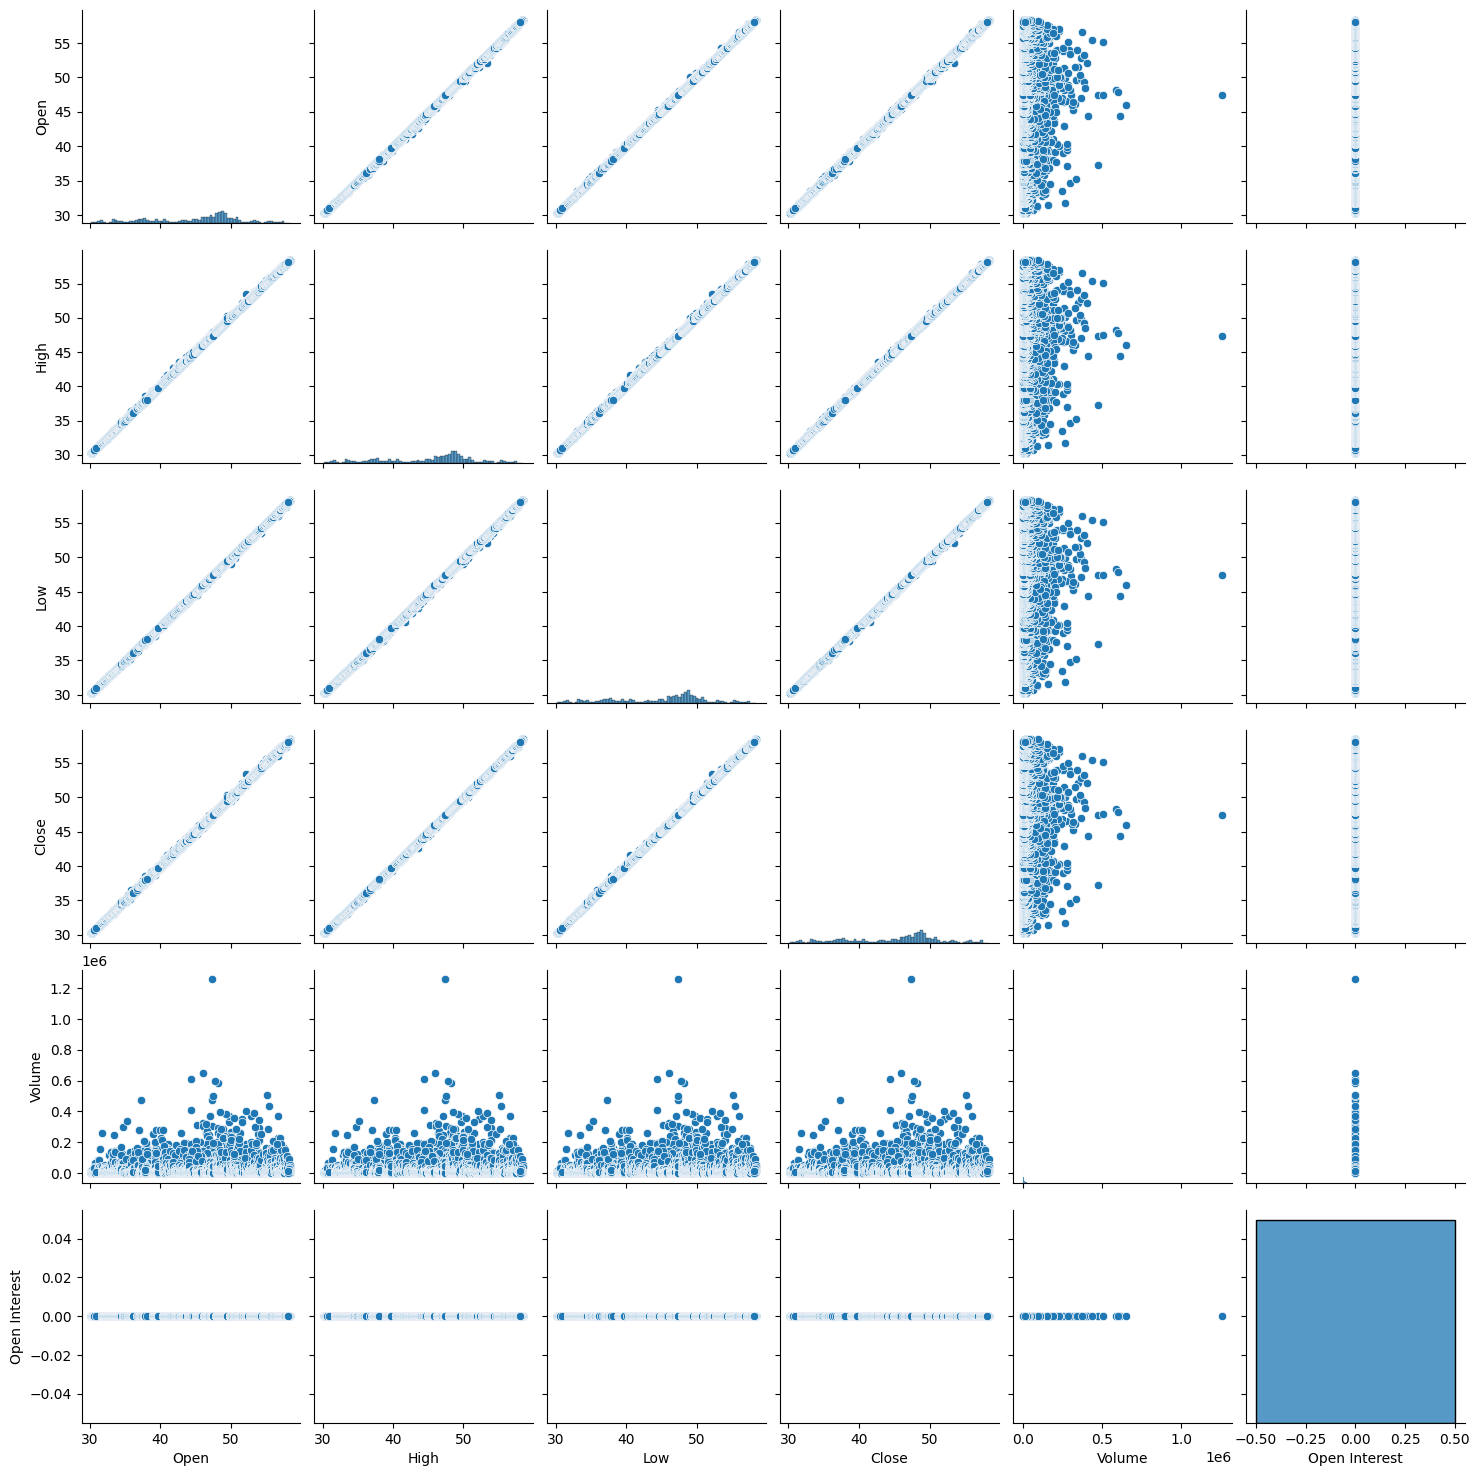

In [7]:
# Vẽ biểu đồ tương quan
sns.pairplot(df_fpt)
plt.show()

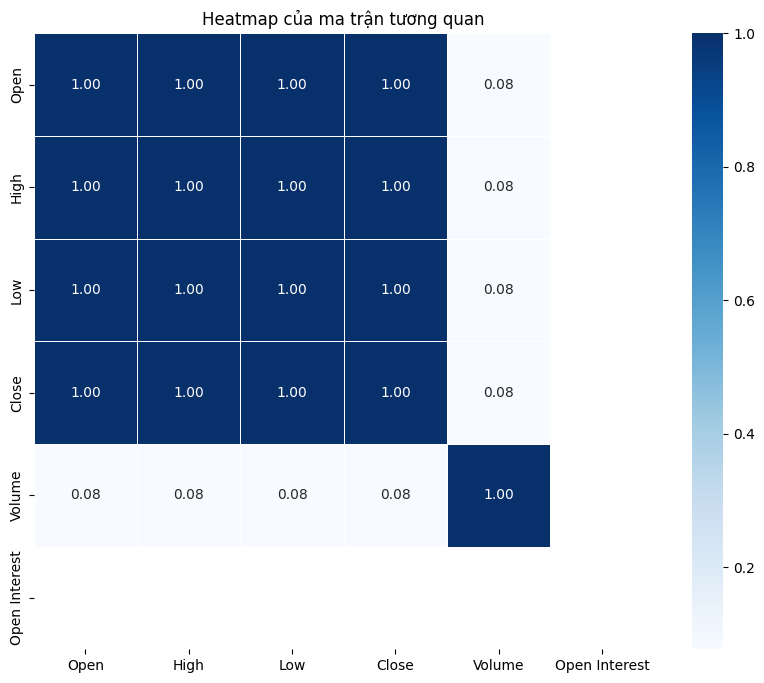

In [8]:
# Tính toán ma trận tương quan cho các cột số
numeric_columns = df_fpt.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_columns.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title("Heatmap của ma trận tương quan")
plt.show()

In [11]:
def visualize(df):
    # Lấy thông tin năm từ cột "Ngày"
    df['Year'] = df['Date/Time'].dt.year

    # Tạo đồ thị giá đóng cửa qua các năm
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date/Time'], df['Close'], label='Giá đóng cửa', color='blue')
    plt.xlabel('Năm')
    plt.ylabel('Giá đóng cửa')
    plt.title('Biểu đồ giá đóng cửa của FPT qua các năm')
    plt.legend(loc='best')

    # Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
    years = YearLocator()
    yearsFmt = DateFormatter('%Y')
    months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
    plt.gca().xaxis.set_major_locator(years)
    plt.gca().xaxis.set_major_formatter(yearsFmt)
    plt.gca().xaxis.set_minor_locator(months)

    plt.tight_layout()
    plt.show()

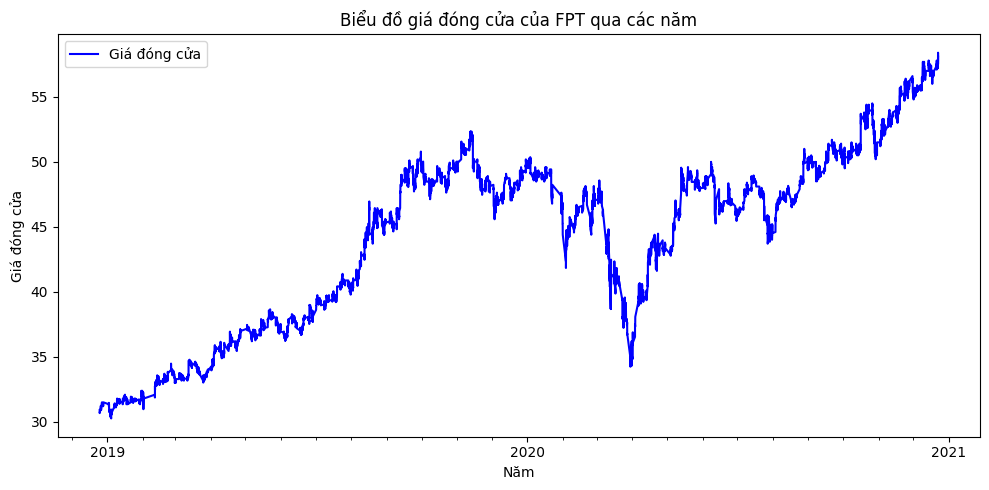

In [12]:
visualize(df_fpt)

# **Chia tập dữ liệu**

In [13]:
#chia tập dữ liệu
df1 = pd.DataFrame(df_fpt,columns=['Date/Time','Close'])
df1.index = df1['Date/Time']
df1.drop('Date/Time',axis=1,inplace=True)
df1

,Close
Date/Time,
2018-12-25 09:15:00,30.89
2018-12-25 09:16:00,30.81
2018-12-25 09:17:00,30.74
2018-12-25 09:18:00,30.74
2018-12-25 09:19:00,30.74
...,...
2020-12-22 14:24:00,58.20
2020-12-22 14:25:00,58.20
2020-12-22 14:26:00,58.20


In [14]:
#chia tập dữ liệu
data = df1.values
train_data = data[:70000]
test_data = data[70000:]

In [15]:
sc = MinMaxScaler(feature_range=(0,1))
sc_train = sc.fit_transform(data)

In [16]:
#tạo vòng lặp các giá trị
X_train,y_train=[],[]
for i in range(50,len(train_data)):
  X_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [17]:
#Print X_train và y_train đầu tiên
print("X_train đầu tiên: " + str(X_train[1]))
print("y_train đầu tiên: " + str(y_train[1]))

X_train đầu tiên: [0.01989343 0.01740675 0.01740675 0.01740675 0.01740675 0.01456483
 0.03055062 0.03339254 0.03339254 0.03197158 0.03055062 0.03055062
 0.03055062 0.03339254 0.03339254 0.03055062 0.03445826 0.03445826
 0.02806394 0.02806394 0.02522202 0.02522202 0.02522202 0.02522202
 0.02273535 0.02273535 0.02522202 0.02273535 0.02273535 0.02522202
 0.02522202 0.02806394 0.03339254 0.03055062 0.03197158 0.03197158
 0.03055062 0.03055062 0.03055062 0.03055062 0.03339254 0.03339254
 0.03339254 0.03055062 0.03055062 0.03055062 0.03055062 0.03055062
 0.03197158 0.03197158]
y_train đầu tiên: 0.030550621669626965


In [18]:
#xếp dữ liệu thành 1 mảng 2 chiều
X_train = np.array(X_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [19]:
y_train

array([[0.03197158],
       [0.03055062],
       [0.03197158],
       ...,
       [0.62522202],
       [0.62699822],
       [0.62522202]])

# **Tạo model LSTM và huấn luyện**

In [20]:
model = Sequential()
model.add(LSTM(units=256,input_shape=(X_train.shape[1],1),return_sequences=True))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mean_absolute_error")
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 256)        │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,169 (2.00 MB)

 Trainable params: 523,169 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Định nghĩa callback EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

# Định nghĩa callback ModelCheckpoint để lưu mô hình tốt nhất
save_model = "/kaggle/working/model_fpt.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Huấn luyện mô hình với các callbacks
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[early_stopping, best_model])


Epoch 1/100

Epoch 1: loss improved from inf to 0.05073, saving model to /kaggle/working/model_fpt.keras
1093/1093 - 18s - 16ms/step - loss: 0.0507
Epoch 2/100

Epoch 2: loss improved from 0.05073 to 0.03074, saving model to /kaggle/working/model_fpt.keras
1093/1093 - 12s - 11ms/step - loss: 0.0307
Epoch 3/100

Epoch 3: loss improved from 0.03074 to 0.02911, saving model to /kaggle/working/model_fpt.keras
1093/1093 - 12s - 11ms/step - loss: 0.0291
Epoch 4/100

Epoch 4: loss improved from 0.02911 to 0.02865, saving model to /kaggle/working/model_fpt.keras
1093/1093 - 12s - 11ms/step - loss: 0.0286
Epoch 5/100

Epoch 5: loss improved from 0.02865 to 0.02852, saving model to /kaggle/working/model_fpt.keras
1093/1093 - 12s - 11ms/step - loss: 0.0285
Epoch 6/100

Epoch 6: loss improved from 0.02852 to 0.02825, saving model to /kaggle/working/model_fpt.keras
1093/1093 - 12s - 11ms/step - loss: 0.0283
Epoch 7/100

Epoch 7: loss did not improve from 0.02825
1093/1093 - 12s - 11ms/step - loss: 

In [22]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/kaggle/working/model_fpt.keras")
y_train_predict = final_model.predict(X_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

2186/2186 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [23]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

X_test = []
for i in range(50,test.shape[0]):
  X_test.append(sc_test[i-50:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

#dữ liệu test
y_test = data[70000:] #giá thực
y_test_predict = final_model.predict(X_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

857/857 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


/tmp/ipykernel_34/3502370475.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
/tmp/ipykernel_34/3502370475.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


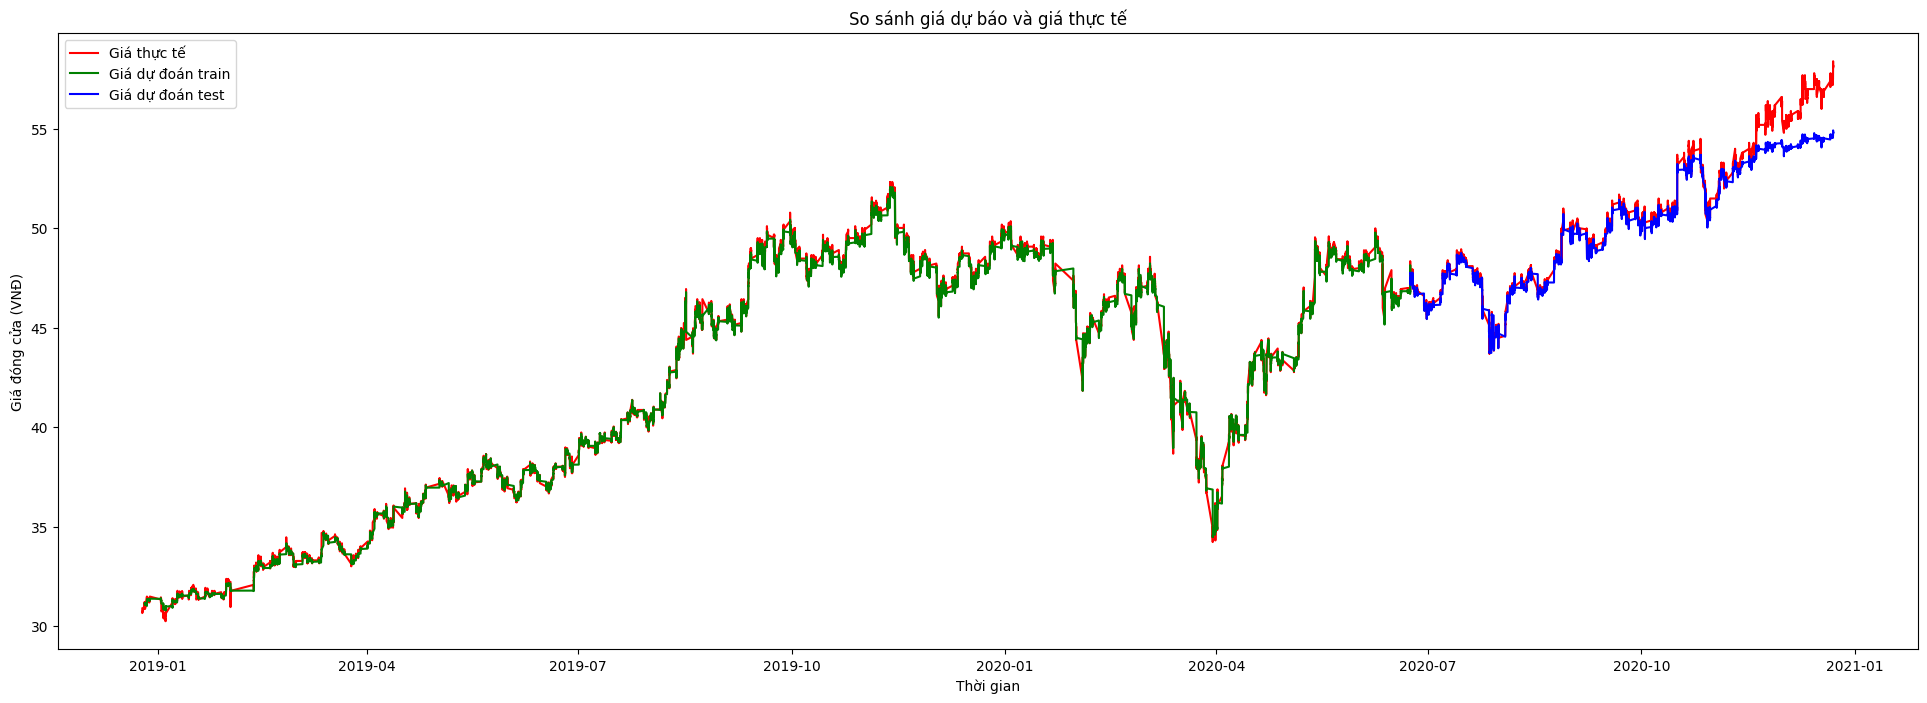

In [24]:
#lập biểu đồ so sánh
train_data1 = df1[50:70000]
test_data1 = df1[70000:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [25]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9995087586740828
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.09900167422509347
Phần trăm sai số tuyệt đối trung bình tập train: 0.0022341226995380467


In [26]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9344752330506562
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.506093850296222
Phần trăm sai số tuyệt đối trung bình tập test: 0.00926932679627296


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


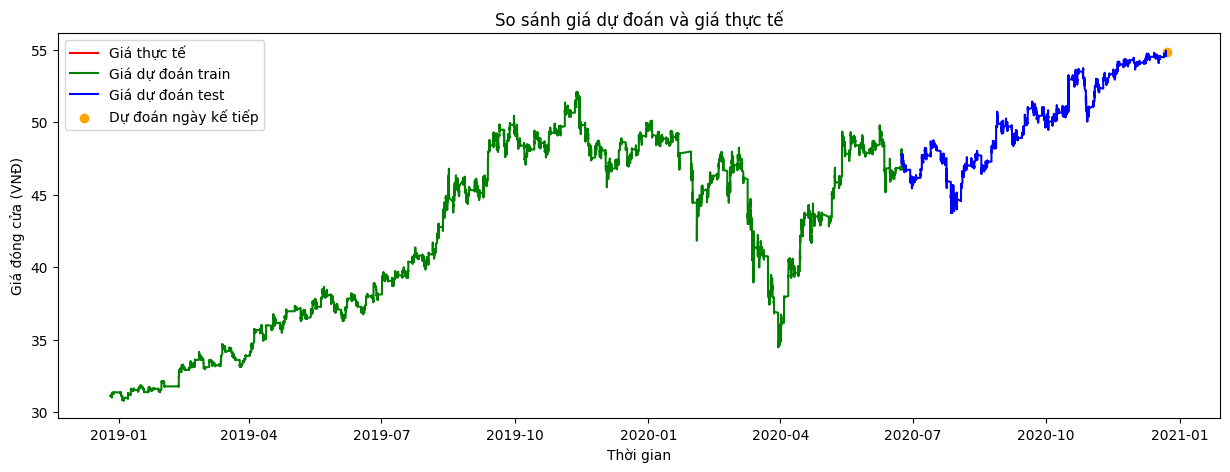

In [27]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df_fpt['Date/Time'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df_fpt['Close'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Date/Time': [next_date], 'Close': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Date/Time'], df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự đoán và giá thực tế')
plt.legend()
plt.show()
